In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/home/william/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
df_paths = [
    "/home/william/lidar_data/PRA_vehicles_runs/metrics.csv",
    "/home/william/lidar_data/PRA_pedestrians_runs/metrics.csv",
    "/home/william/lidar_data/ORA_vehicles_runs/metrics.csv",
    "/home/william/lidar_data/ORA_pedestrians_runs/metrics.csv",
]

# join all dataframes
df = pd.concat([pd.read_csv(path) for path in df_paths])

In [3]:
# organize based on the run_id by adding columns for PRA/ORA, pedestrian/vehicle, attack angle, point budget, and attack distance

# if PRA, the run id will look like "PRA_pedestrians_10_stereo_scenario_0"
# meaning the scenario is "stereo_scenario_0", the attack is PRA, attacking pedestrians, 10 degree attack angle

# if ORA, the run id will look like "ORA_pedestrians_10_3m_stereo_scenario_0"
# meaning the scenario is "stereo_scenario_0", the attack is ORA, attacking pedestrians, point budget of 10, 3m attack distance

# mark the lidar configuration (stereo, stacked, single)
lidar_configs = {"stereo", "stacked", "single"}
df["lidar_config"] = df["run_id"].apply(lambda x: next((config for config in lidar_configs if config in x), None))

# mark the scenario
df["scenario"] = df["run_id"].apply(lambda x: x.split("_")[-1])

# mark the attacking type
df["attacking"] = df["run_id"].apply(lambda x: "CAR" if "vehicles" in x else "PEDESTRIAN")

# filter out where attacking != class
df = df[df["attacking"] == df["class"]]

# round iou thresholds since some are like 0.60000000001
df["iou_threshold"] = df["iou_threshold"].apply(lambda x: round(x, 2))

# split the dataframes into PRA and ORA
pra_df = df[df["run_id"].apply(lambda x: "PRA" in x)]
ora_df = df[df["run_id"].apply(lambda x: "ORA" in x)]

# for PRA, get the attack angle
pra_df["attack_angle"] = pra_df["run_id"].apply(lambda x: int(x.split("_")[2]))

# for ORA, get the point budget
ora_df["point_budget"] = ora_df["run_id"].apply(lambda x: int(x.split("_")[2]))

/tmp/ipykernel_270072/4190464243.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pra_df["attack_angle"] = pra_df["run_id"].apply(lambda x: int(x.split("_")[2]))
/tmp/ipykernel_270072/4190464243.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ora_df["point_budget"] = ora_df["run_id"].apply(lambda x: int(x.split("_")[2]))


In [4]:
# calculate the ASR for PRA vehicles
# where baseline is 0 attack angle, the ASR is the (baseline_tp - attacked_tp) / baseline_tp
pra_veh_df = pra_df[pra_df["class"] == "CAR"]
pra_veh_df_baselines = pra_veh_df[pra_veh_df["attack_angle"] == 0]
pra_veh_df_attacked = pra_veh_df[pra_veh_df["attack_angle"] != 0]

pra_veh_df["asr"] = 0

# loop through attacked and calculate the asr for each
for idx, row in pra_veh_df_attacked.iterrows():
    # find the row in pra_veh_df_baselines that matches
    matching_baseline = pra_veh_df_baselines[(pra_veh_df_baselines["lidar_config"] == row["lidar_config"]) & (pra_veh_df_baselines["scenario"] == row["scenario"]) & (pra_veh_df_baselines["iou_threshold"] == row["iou_threshold"])]
    matching_baseline = matching_baseline.iloc[0]
    
    baseline_tp = matching_baseline["tp"]
    
    # calculate asr
    if baseline_tp == 0:
        asr = 0
    else:
        asr = (baseline_tp - row["tp"]) / baseline_tp
    
    # if we have more tp somehow, just make asr 0
    asr = max(asr, 0)
    
    pra_veh_df.at[idx, "asr"] = asr

pra_veh_df.head()

/tmp/ipykernel_270072/4167012895.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pra_veh_df["asr"] = 0


,run_id,class,iou_threshold,avg_conf,tp,fp,fn,lidar_config,scenario,attacking,attack_angle,asr
0,PRA_vehicles_10_single_scenario_2,CAR,0.0,0.020181,1016,273,317,single,2,CAR,10,0.358181
2,PRA_vehicles_10_single_scenario_2,CAR,0.1,0.096717,212,1077,317,single,2,CAR,10,0.784334
4,PRA_vehicles_10_single_scenario_2,CAR,0.2,0.183072,112,1177,317,single,2,CAR,10,0.826087
6,PRA_vehicles_10_single_scenario_2,CAR,0.3,0.347526,59,1230,317,single,2,CAR,10,0.847545
8,PRA_vehicles_10_single_scenario_2,CAR,0.4,0.426491,45,1244,317,single,2,CAR,10,0.754098


In [5]:
# calculate the ASR for PRA pedestrians
# where baseline is 0 attack angle, the ASR is the (baseline_tp - attacked_tp) / baseline_tp
pra_ped_df = pra_df[pra_df["class"] == "PEDESTRIAN"]
pra_ped_df_baselines = pra_ped_df[pra_ped_df["attack_angle"] == 0]
pra_ped_df_attacked = pra_ped_df[pra_ped_df["attack_angle"] != 0]

pra_ped_df["asr"] = 0

# loop through attacked and calculate the asr for each
for idx, row in pra_ped_df_attacked.iterrows():
    # find the row in pra_veh_df_baselines that matches
    matching_baseline = pra_ped_df_baselines[(pra_ped_df_baselines["lidar_config"] == row["lidar_config"]) & (pra_ped_df_baselines["scenario"] == row["scenario"]) & (pra_ped_df_baselines["iou_threshold"] == row["iou_threshold"])]
    matching_baseline = matching_baseline.iloc[0]
    
    baseline_tp = matching_baseline["tp"]
    
    # calculate asr
    if baseline_tp == 0:
        asr = 0
    else:
        asr = (baseline_tp - row["tp"]) / baseline_tp
    
    # if we have more tp somehow, just make asr 0
    asr = max(asr, 0)
    
    # HELP: Update asr in pra_ped_df at this row 
    pra_ped_df.at[idx, "asr"] = asr

pra_ped_df.head()

/tmp/ipykernel_270072/538568191.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pra_ped_df["asr"] = 0


,run_id,class,iou_threshold,avg_conf,tp,fp,fn,lidar_config,scenario,attacking,attack_angle,asr
0,PRA_pedestrians_0_stereo_scenario_1,PEDESTRIAN,0.0,0.034269,1036,197,276,stereo,1,PEDESTRIAN,0,0.0
2,PRA_pedestrians_0_stereo_scenario_1,PEDESTRIAN,0.1,0.046766,697,536,276,stereo,1,PEDESTRIAN,0,0.0
4,PRA_pedestrians_0_stereo_scenario_1,PEDESTRIAN,0.2,0.059915,391,842,276,stereo,1,PEDESTRIAN,0,0.0
6,PRA_pedestrians_0_stereo_scenario_1,PEDESTRIAN,0.3,0.000000,142,1091,276,stereo,1,PEDESTRIAN,0,0.0
8,PRA_pedestrians_0_stereo_scenario_1,PEDESTRIAN,0.4,0.000000,37,1196,276,stereo,1,PEDESTRIAN,0,0.0


In [6]:
# create confusion matrices grouped by iou_threshold, lidar_config, and attack_angle
pra_veh_cm = pra_veh_df.groupby(["iou_threshold", "lidar_config", "attack_angle"])[['tp', 'fp', 'fn']].sum().reset_index()

# add column for average asr
pra_veh_asr = pra_veh_df.groupby(["iou_threshold", "lidar_config", "attack_angle"])[['asr']].mean().reset_index()
pra_veh_cm["asr"] = pra_veh_asr["asr"]

# for each iou_threshold, lidar_config, and attack_angle, calculate the precision, recall, and attack success rate
pra_veh_metrics = []
for iou_threshold in pra_veh_cm["iou_threshold"].unique():
    for lidar_config in pra_veh_cm["lidar_config"].unique():
        for attack_angle in pra_veh_cm["attack_angle"].unique():
            attack_df = pra_veh_cm[(pra_veh_cm["iou_threshold"] == iou_threshold) & (pra_veh_cm["lidar_config"] == lidar_config) & (pra_veh_cm["attack_angle"] == attack_angle)]
            tp, fp, fn = attack_df["tp"].values[0], attack_df["fp"].values[0], attack_df["fn"].values[0]
            asr = attack_df["asr"].values[0]
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            pra_veh_metrics.append({
                "iou_threshold": iou_threshold,
                "lidar_config": lidar_config,
                "attack_angle": attack_angle,
                "precision": precision,
                "recall": recall,
                "attack_success_rate": asr
            })

pra_veh_metrics_df = pd.DataFrame(pra_veh_metrics)
pra_veh_metrics_df

,iou_threshold,lidar_config,attack_angle,precision,recall,attack_success_rate
0,0.0,single,0,0.961146,0.994425,0.000000
1,0.0,single,5,0.908968,0.917350,0.204301
2,0.0,single,10,0.818617,0.712609,0.439334
3,0.0,single,20,0.728188,0.421032,0.678084
4,0.0,single,40,0.754438,0.207065,0.849210
...,...,...,...,...,...,...
160,1.0,stereo,0,0.000000,0.000000,0.000000
161,1.0,stereo,5,0.000000,0.000000,0.000000
162,1.0,stereo,10,0.000000,0.000000,0.000000
163,1.0,stereo,20,0.000000,0.000000,0.000000


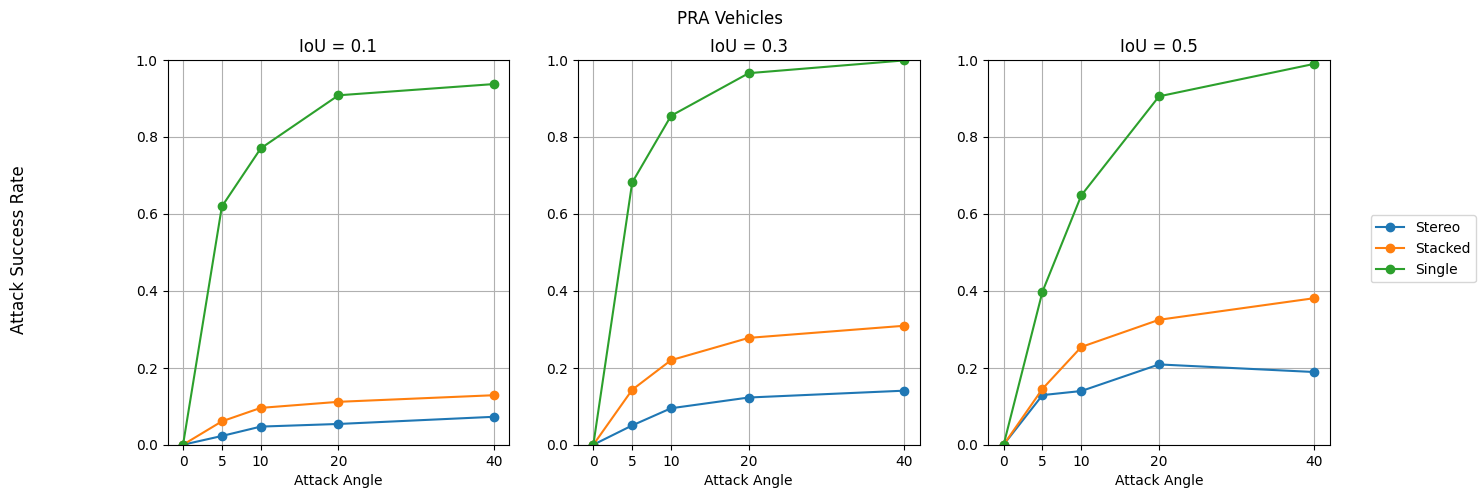

In [7]:
# plot the attack success rate over attack angle for each lidar configuration (each configuration is a line)
# 3 different iou thresholds

iou_thresholds = [0.1, 0.3, 0.5]
lidar_configs = ["stereo", "stacked", "single"]
to_label = {"stereo": "Stereo", "stacked": "Stacked", "single": "Single"}

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, iou_threshold in enumerate(iou_thresholds):
    for lidar_config in lidar_configs:
        data = pra_veh_metrics_df[(pra_veh_metrics_df["iou_threshold"] == iou_threshold) & (pra_veh_metrics_df["lidar_config"] == lidar_config)]
        ax[i].plot(data["attack_angle"], data["attack_success_rate"], label=to_label[lidar_config], marker='o')
    ax[i].grid()
    ax[i].set_title(f"IoU = {iou_threshold}")
    ax[i].set_xlabel("Attack Angle")
    ax[i].set_xticks(data["attack_angle"].unique())
    ax[i].set_ylim([0, 1])
fig.supylabel("Attack Success Rate")
fig.suptitle("PRA Vehicles")
handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
# fig.tight_layout()
plt.show()
fig.savefig("PRA_Vehicles_ASR.png")

In [8]:
# same, but for pedestrians
pra_ped_cm = pra_ped_df.groupby(["iou_threshold", "lidar_config", "attack_angle"])[['tp', 'fp', 'fn']].sum().reset_index()

# add column for average asr
pra_ped_asr = pra_ped_df.groupby(["iou_threshold", "lidar_config", "attack_angle"])[['asr']].mean().reset_index()
pra_ped_cm["asr"] = pra_ped_asr["asr"]

pra_ped_metrics = []
for iou_threshold in pra_ped_cm["iou_threshold"].unique():
    for lidar_config in pra_ped_cm["lidar_config"].unique():
        for attack_angle in pra_ped_cm["attack_angle"].unique():
            attack_df = pra_ped_cm[(pra_ped_cm["iou_threshold"] == iou_threshold) & (pra_ped_cm["lidar_config"] == lidar_config) & (pra_ped_cm["attack_angle"] == attack_angle)]
            tp, fp, fn = attack_df["tp"].values[0], attack_df["fp"].values[0], attack_df["fn"].values[0]
            asr = attack_df["asr"].values[0]
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            pra_ped_metrics.append({
                "iou_threshold": iou_threshold,
                "lidar_config": lidar_config,
                "attack_angle": attack_angle,
                "precision": precision,
                "recall": recall,
                "attack_success_rate": asr
            })

pra_ped_metrics_df = pd.DataFrame(pra_ped_metrics)
pra_ped_metrics_df

,iou_threshold,lidar_config,attack_angle,precision,recall,attack_success_rate
0,0.0,single,0,0.329609,0.279180,0.000000
1,0.0,single,5,0.267901,0.114997,0.534348
2,0.0,single,10,0.293458,0.083201,0.708994
3,0.0,stacked,0,0.876866,0.844185,0.000000
4,0.0,stacked,5,0.847095,0.713550,0.263225
...,...,...,...,...,...,...
94,1.0,stacked,5,0.000000,0.000000,0.000000
95,1.0,stacked,10,0.000000,0.000000,0.000000
96,1.0,stereo,0,0.000000,0.000000,0.000000
97,1.0,stereo,5,0.000000,0.000000,0.000000


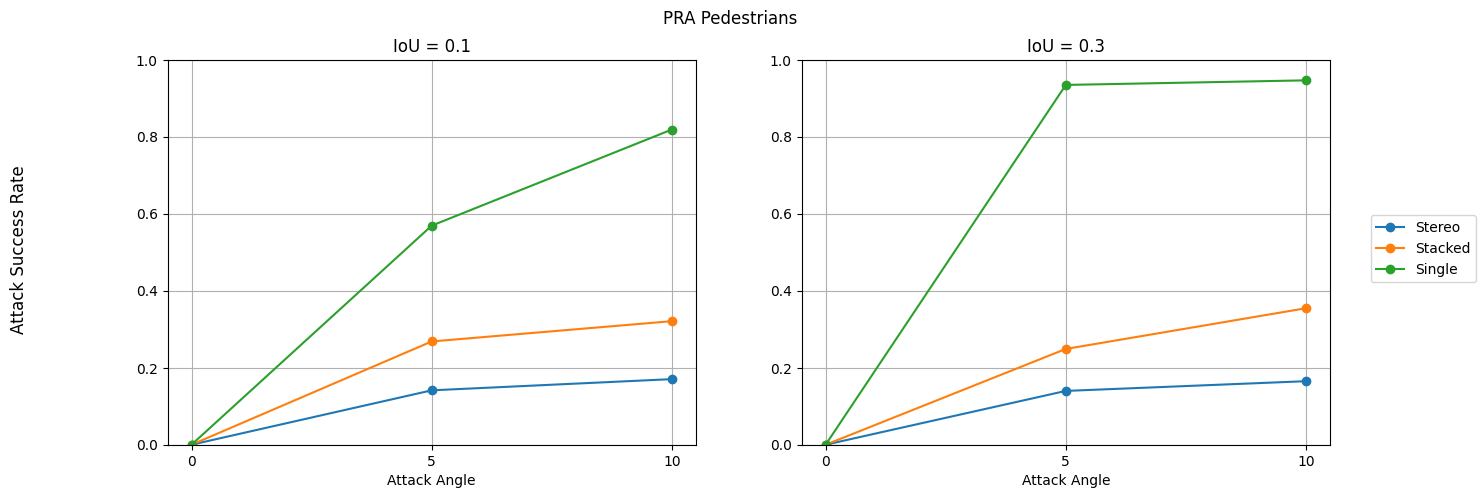

In [9]:
# same plot, but for pedestrians this time
iou_thresholds = [0.1, 0.3]
lidar_configs = ["stereo", "stacked", "single"]
to_label = {"stereo": "Stereo", "stacked": "Stacked", "single": "Single"}

fig, ax = plt.subplots(1, len(iou_thresholds), figsize=(15, 5))
for i, iou_threshold in enumerate(iou_thresholds):
    for lidar_config in lidar_configs:
        data = pra_ped_metrics_df[(pra_ped_metrics_df["iou_threshold"] == iou_threshold) & (pra_ped_metrics_df["lidar_config"] == lidar_config)]
        ax[i].plot(data["attack_angle"], data["attack_success_rate"], label=to_label[lidar_config], marker='o')
    ax[i].grid()
    ax[i].set_title(f"IoU = {iou_threshold}")
    ax[i].set_xlabel("Attack Angle")
    ax[i].set_xticks(data["attack_angle"].unique())
    ax[i].set_ylim([0, 1])
fig.supylabel("Attack Success Rate")
fig.suptitle("PRA Pedestrians")
handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
# fig.tight_layout()
plt.show()
fig.savefig("PRA_Pedestrians_ASR.png")

In [10]:
# create confusion matrices grouped by iou_threshold, lidar_config, and point budget
ora_veh_df = ora_df[ora_df["class"] == "CAR"]
ora_veh_cm = ora_veh_df.groupby(["iou_threshold", "lidar_config", "point_budget"])[['tp', 'fp', 'fn']].sum().reset_index()

# add the averaged confidence values
ora_veh_conf = ora_veh_df.groupby(["iou_threshold", "lidar_config", "point_budget"])[['avg_conf']].mean().reset_index()
ora_veh_cm["avg_conf"] = ora_veh_conf["avg_conf"]

# for each iou_threshold, lidar_config, and point_budget, calculate the precision, recall, and attack success rate
ora_veh_metrics = []
for iou_threshold in ora_veh_cm["iou_threshold"].unique():
    for lidar_config in ora_veh_cm["lidar_config"].unique():
        for point_budget in ora_veh_cm["point_budget"].unique():
            attack_df = ora_veh_cm[(ora_veh_cm["iou_threshold"] == iou_threshold) & (ora_veh_cm["lidar_config"] == lidar_config) & (ora_veh_cm["point_budget"] == point_budget)]
            
            tp, fp, fn = attack_df["tp"].values[0], attack_df["fp"].values[0], attack_df["fn"].values[0]
            
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)

            conf = attack_df["avg_conf"].values[0]
            
            ora_veh_metrics.append({
                "iou_threshold": iou_threshold,
                "lidar_config": lidar_config,
                "point_budget": point_budget,
                "precision": precision,
                "recall": recall,
                "conf": conf
            })

ora_veh_metrics_df = pd.DataFrame(ora_veh_metrics)
ora_veh_metrics_df

,iou_threshold,lidar_config,point_budget,precision,recall,conf
0,0.0,single,100,0.954303,0.981685,0.017567
1,0.0,single,200,0.940762,0.978347,0.011832
2,0.0,single,400,0.937628,0.975030,0.004576
3,0.0,stacked,100,0.978626,0.999221,0.240990
4,0.0,stacked,200,0.979374,0.999221,0.226898
...,...,...,...,...,...,...
94,1.0,stacked,200,0.000000,0.000000,0.000000
95,1.0,stacked,400,0.000000,0.000000,0.000000
96,1.0,stereo,100,0.000000,0.000000,0.000000
97,1.0,stereo,200,0.000000,0.000000,0.000000


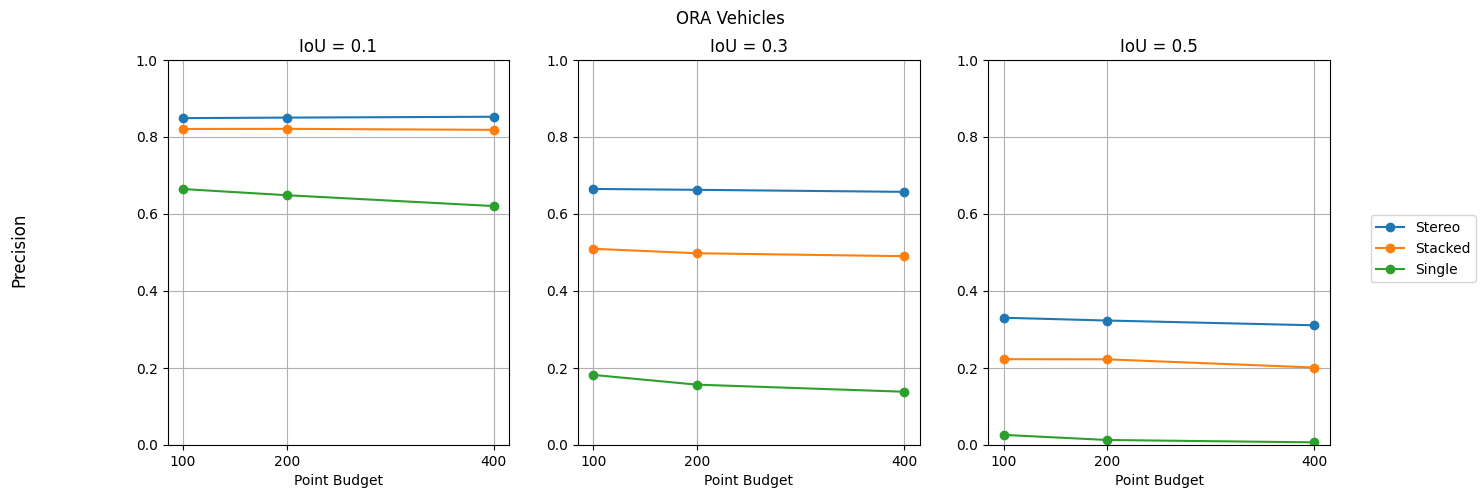

In [11]:
# plot the precision over point budget for each lidar configuration (each configuration is a line)
# 3 different iou thresholds

iou_thresholds = [0.1, 0.3, 0.5]
lidar_configs = ["stereo", "stacked", "single"]
to_label = {"stereo": "Stereo", "stacked": "Stacked", "single": "Single"}

fig, ax = plt.subplots(1, len(iou_thresholds), figsize=(15, 5))
for i, iou_threshold in enumerate(iou_thresholds):
    for lidar_config in lidar_configs:
        data = ora_veh_metrics_df[(ora_veh_metrics_df["iou_threshold"] == iou_threshold) & (ora_veh_metrics_df["lidar_config"] == lidar_config)]
        ax[i].plot(data["point_budget"], data["precision"], label=to_label[lidar_config], marker='o')
    ax[i].grid()
    ax[i].set_xticks(data["point_budget"].unique())
    ax[i].set_title(f"IoU = {iou_threshold}")
    ax[i].set_xlabel("Point Budget")
    ax[i].set_ylim([0, 1])
fig.suptitle("ORA Vehicles")
fig.supylabel("Precision")
handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
plt.show()
fig.savefig("ORA_Vehicles_Precision.png")

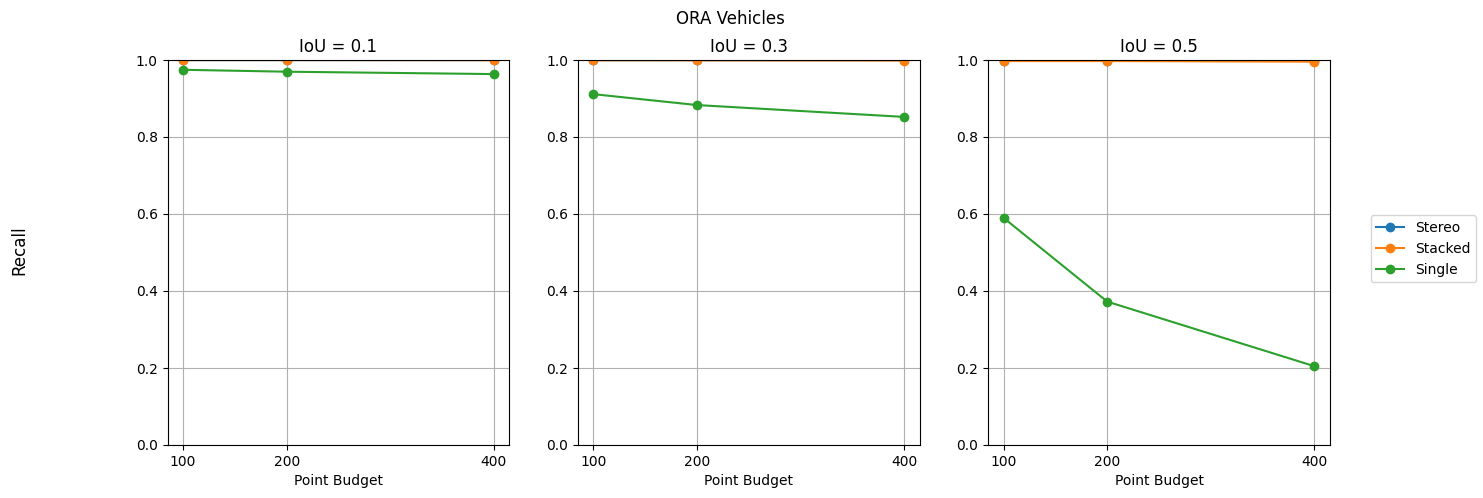

In [12]:
# plot the recall over point budget for each lidar configuration (each configuration is a line)
# 3 different iou thresholds

iou_thresholds = [0.1, 0.3, 0.5]
lidar_configs = ["stereo", "stacked", "single"]
to_label = {"stereo": "Stereo", "stacked": "Stacked", "single": "Single"}

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, iou_threshold in enumerate(iou_thresholds):
    for lidar_config in lidar_configs:
        data = ora_veh_metrics_df[(ora_veh_metrics_df["iou_threshold"] == iou_threshold) & (ora_veh_metrics_df["lidar_config"] == lidar_config)]
        ax[i].plot(data["point_budget"], data["recall"], label=to_label[lidar_config], marker='o')
    ax[i].grid()
    ax[i].set_xticks(data["point_budget"].unique())
    ax[i].set_title(f"IoU = {iou_threshold}")
    ax[i].set_xlabel("Point Budget")
    ax[i].set_ylim([0, 1])
fig.suptitle("ORA Vehicles")
fig.supylabel("Recall")
handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
plt.show()
fig.savefig("ORA_Vehicles_Recall.png")

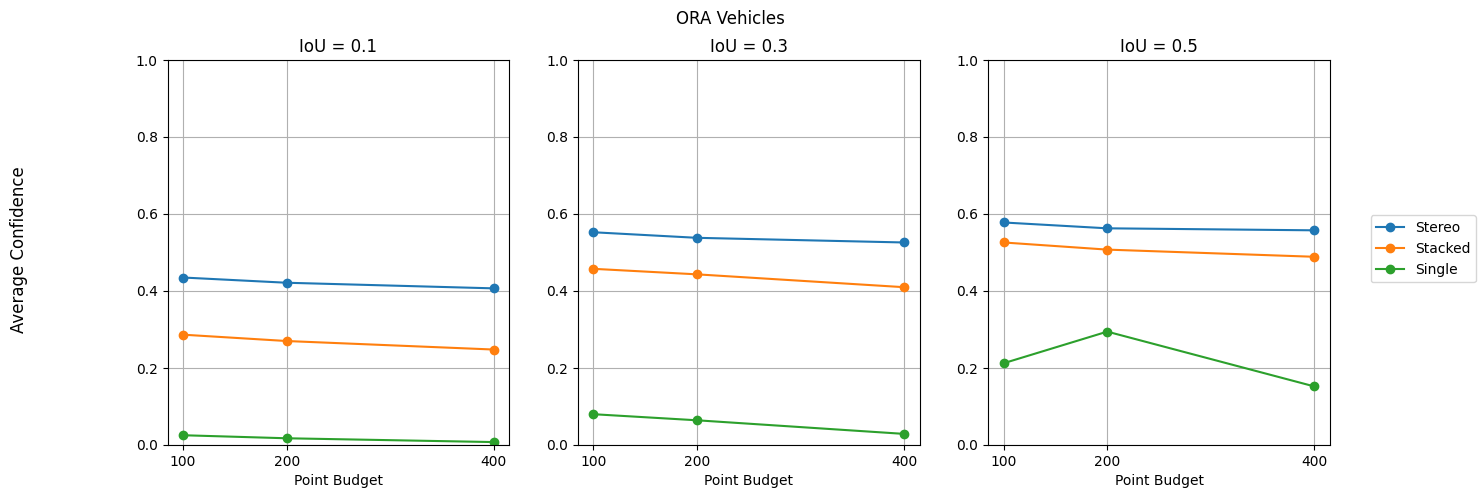

In [13]:
# plot the avg conf over point budget for each lidar configuration (each configuration is a line)
# 3 different iou thresholds

iou_thresholds = [0.1, 0.3, 0.5]
lidar_configs = ["stereo", "stacked", "single"]
to_label = {"stereo": "Stereo", "stacked": "Stacked", "single": "Single"}

fig, ax = plt.subplots(1, len(iou_thresholds), figsize=(15, 5))
for i, iou_threshold in enumerate(iou_thresholds):
    for lidar_config in lidar_configs:
        data = ora_veh_metrics_df[(ora_veh_metrics_df["iou_threshold"] == iou_threshold) & (ora_veh_metrics_df["lidar_config"] == lidar_config)]
        ax[i].plot(data["point_budget"], data["conf"], label=to_label[lidar_config], marker='o')
    ax[i].grid()
    ax[i].set_xticks(data["point_budget"].unique())
    ax[i].set_title(f"IoU = {iou_threshold}")
    ax[i].set_xlabel("Point Budget")
    ax[i].set_ylim([0, 1])
fig.suptitle("ORA Vehicles")
fig.supylabel("Average Confidence")
handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
plt.show()
fig.savefig("ORA_Vehicles_Confidence.png")

In [14]:
# create confusion matrices grouped by iou_threshold, lidar_config, and point budget
ora_ped_df = ora_df[ora_df["class"] == "PEDESTRIAN"]
ora_ped_cm = ora_ped_df.groupby(["iou_threshold", "lidar_config", "point_budget"])[['tp', 'fp', 'fn']].sum().reset_index()

# add the averaged confidence values
ora_ped_conf = ora_ped_df.groupby(["iou_threshold", "lidar_config", "point_budget"])[['avg_conf']].mean().reset_index()
ora_ped_cm["avg_conf"] = ora_ped_conf["avg_conf"]

# for each iou_threshold, lidar_config, and point_budget, calculate the precision, recall, and attack success rate
ora_ped_metrics = []
for iou_threshold in ora_ped_cm["iou_threshold"].unique():
    for lidar_config in ora_ped_cm["lidar_config"].unique():
        for point_budget in ora_ped_cm["point_budget"].unique():
            attack_df = ora_ped_cm[(ora_ped_cm["iou_threshold"] == iou_threshold) & (ora_ped_cm["lidar_config"] == lidar_config) & (ora_ped_cm["point_budget"] == point_budget)]
            
            tp, fp, fn = attack_df["tp"].values[0], attack_df["fp"].values[0], attack_df["fn"].values[0]
            
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)

            conf = attack_df["avg_conf"].values[0]
            
            ora_ped_metrics.append({
                "iou_threshold": iou_threshold,
                "lidar_config": lidar_config,
                "point_budget": point_budget,
                "precision": precision,
                "recall": recall,
                "conf": conf
            })

ora_ped_metrics_df = pd.DataFrame(ora_ped_metrics)
ora_ped_metrics_df

,iou_threshold,lidar_config,point_budget,precision,recall,conf
0,0.0,single,10,0.396469,0.261376,0.000000
1,0.0,single,50,0.178856,0.130206,0.000000
2,0.0,single,100,0.140580,0.102429,0.000000
3,0.0,stacked,10,0.820850,0.790063,0.009290
4,0.0,stacked,50,0.763017,0.763760,0.003663
...,...,...,...,...,...,...
94,1.0,stacked,50,0.000000,0.000000,0.000000
95,1.0,stacked,100,0.000000,0.000000,0.000000
96,1.0,stereo,10,0.000000,0.000000,0.000000
97,1.0,stereo,50,0.000000,0.000000,0.000000


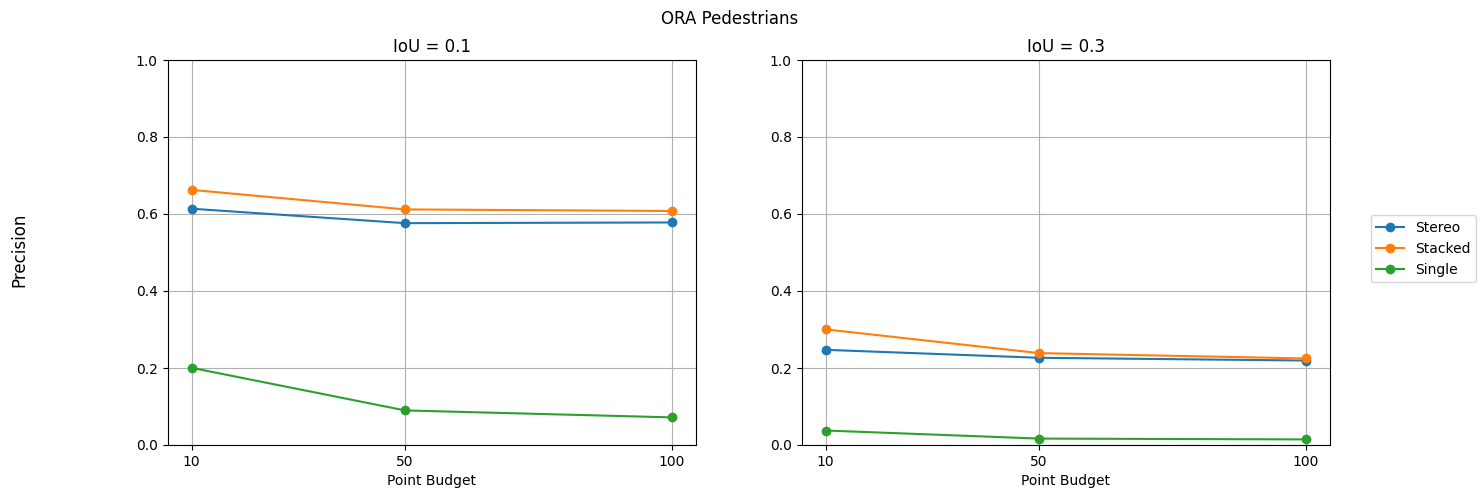

In [15]:
# same plots but for pedestrians
iou_thresholds = [0.1, 0.3]
lidar_configs = ["stereo", "stacked", "single"]
to_label = {"stereo": "Stereo", "stacked": "Stacked", "single": "Single"}

fig, ax = plt.subplots(1, len(iou_thresholds), figsize=(15, 5))
for i, iou_threshold in enumerate(iou_thresholds):
    for lidar_config in lidar_configs:
        data = ora_ped_metrics_df[(ora_ped_metrics_df["iou_threshold"] == iou_threshold) & (ora_veh_metrics_df["lidar_config"] == lidar_config)]
        ax[i].plot(data["point_budget"], data["precision"], label=to_label[lidar_config], marker='o')
    ax[i].grid()
    ax[i].set_xticks(data["point_budget"].unique())
    ax[i].set_title(f"IoU = {iou_threshold}")
    ax[i].set_xlabel("Point Budget")
    ax[i].set_ylim([0, 1])
fig.suptitle("ORA Pedestrians")
fig.supylabel("Precision")
handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
plt.show()
fig.savefig("ORA_Pedestrians_Precision.png")

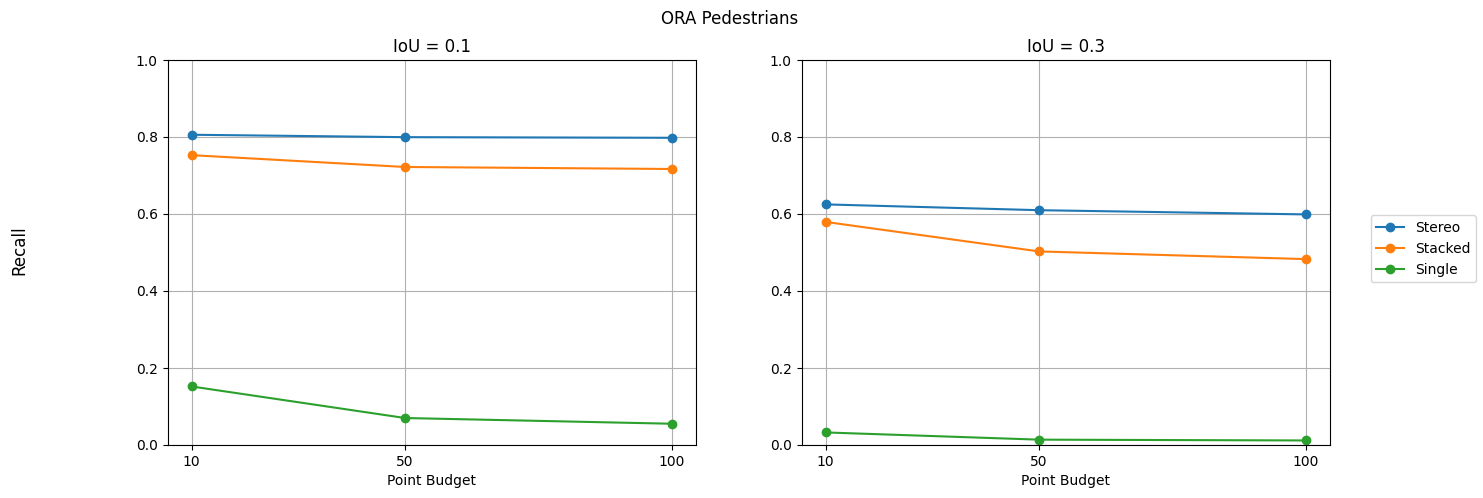

In [16]:
iou_thresholds = [0.1, 0.3]
lidar_configs = ["stereo", "stacked", "single"]
to_label = {"stereo": "Stereo", "stacked": "Stacked", "single": "Single"}

fig, ax = plt.subplots(1, len(iou_thresholds), figsize=(15, 5))
for i, iou_threshold in enumerate(iou_thresholds):
    for lidar_config in lidar_configs:
        data = ora_ped_metrics_df[(ora_ped_metrics_df["iou_threshold"] == iou_threshold) & (ora_ped_metrics_df["lidar_config"] == lidar_config)]
        ax[i].plot(data["point_budget"], data["recall"], label=to_label[lidar_config], marker='o')
    ax[i].grid()
    ax[i].set_xticks(data["point_budget"].unique())
    ax[i].set_title(f"IoU = {iou_threshold}")
    ax[i].set_xlabel("Point Budget")
    ax[i].set_ylim([0, 1])
fig.suptitle("ORA Pedestrians")
fig.supylabel("Recall")
handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
plt.show()
fig.savefig("ORA_Pedestrians_Recall.png")

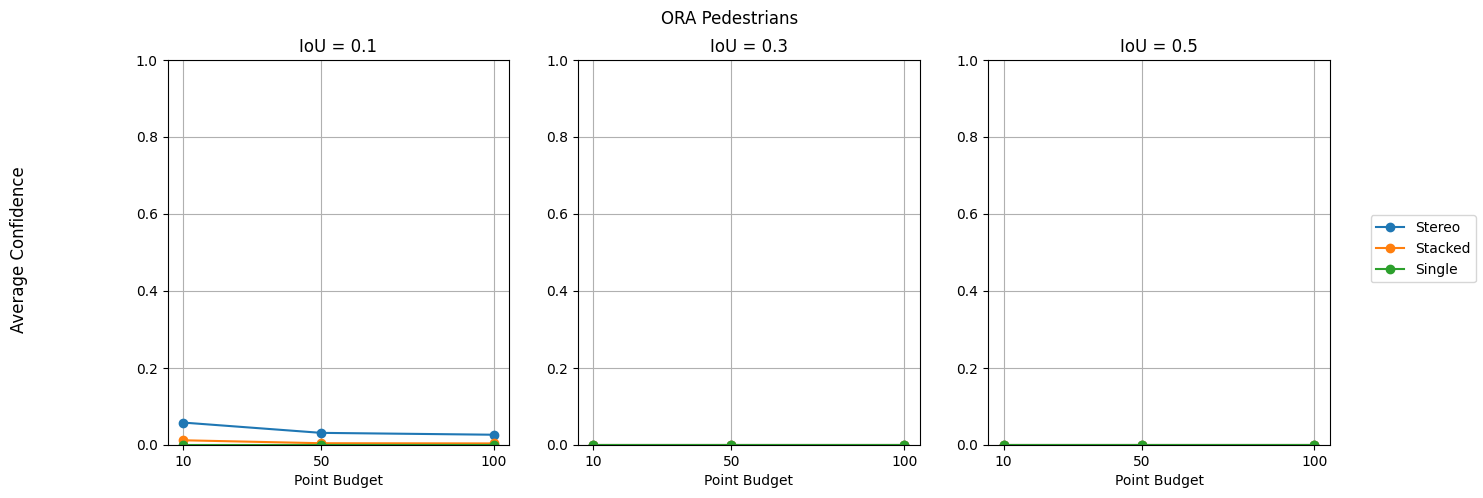

In [17]:
# plot the avg conf over point budget for each lidar configuration (each configuration is a line)
# 3 different iou thresholds

iou_thresholds = [0.1, 0.3, 0.5]
lidar_configs = ["stereo", "stacked", "single"]
to_label = {"stereo": "Stereo", "stacked": "Stacked", "single": "Single"}

fig, ax = plt.subplots(1, len(iou_thresholds), figsize=(15, 5))
for i, iou_threshold in enumerate(iou_thresholds):
    for lidar_config in lidar_configs:
        data = ora_ped_metrics_df[(ora_ped_metrics_df["iou_threshold"] == iou_threshold) & (ora_ped_metrics_df["lidar_config"] == lidar_config)]
        ax[i].plot(data["point_budget"], data["conf"], label=to_label[lidar_config], marker='o')
    ax[i].grid()
    ax[i].set_xticks(data["point_budget"].unique())
    ax[i].set_title(f"IoU = {iou_threshold}")
    ax[i].set_xlabel("Point Budget")
    ax[i].set_ylim([0, 1])
fig.suptitle("ORA Pedestrians")
fig.supylabel("Average Confidence")
handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
plt.show()
fig.savefig("ORA_Pedestrians_Confidence.png")